In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax

# Setup

In [2]:
k = 10          # Number of arms (distributions)

In [3]:
# Generate the true reward for each action
action_values = np.random.randn(k)

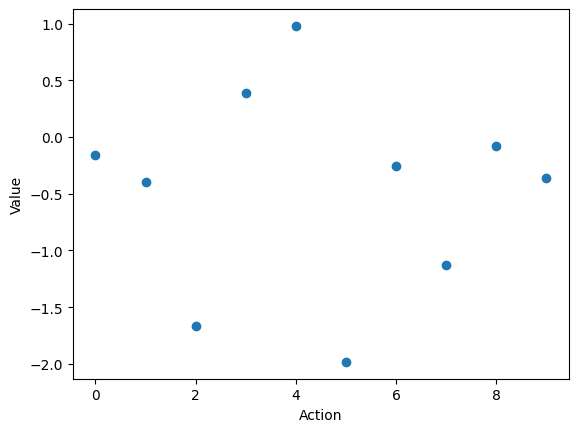

In [4]:
# Plot the values for each k. It should be discrete points, not a line
plt.plot(action_values, 'o')
plt.xlabel('Action')
plt.ylabel('Value')
plt.show()

In [5]:
# Reward is sampled from a distribution with mean
# q*(a), the mean of the given action
def reward_model(action_values, action):
    return np.random.randn() + action_values[action]

In [6]:
# Optimal action is the one with the greatest mean
optimal_action = action_values.argmax()

# Basic Epsilon Search

In [7]:
def epsilon_search(action_values, epsilon, num_iterations=1000, init=0):
    num_actions = action_values.shape[0]
    
    # Q value / estimated reward for each action is 0
    q_values = np.zeros(num_actions) + init
    # Number of times each action has been taken is 0
    n_values = np.zeros(num_actions)
    
    # Average reward
    avg_reward = 0
    
    for it in range(1, num_iterations+1):
        # Random action with probability epsilon
        sample = np.random.rand()
        if sample < epsilon:
            action = np.random.randint(0, num_actions)
        else:
            action = np.argmax(q_values)
            
        # Get the reward for the given action
        reward = reward_model(action_values, action)
        
        avg_reward += reward
        
        # Update the q values and n values
        n_values[action] += 1
        q_values[action] = q_values[action] + 1/n_values[action] * (reward - q_values[action])
        
    return q_values, avg_reward/num_iterations

In [8]:
# Test
pred, avg_reward = epsilon_search(action_values, 0.1, 10000)
# MSE
print(
    "MSE",
    ((pred-action_values)**2).mean()
)
print(pred)
print(action_values)
print(avg_reward)

MSE 0.010974502899930573
[-0.17171225 -0.39328213 -1.8378916   0.42082669  0.97542771 -2.0896267
 -0.37673618 -1.34289793 -0.00615886 -0.33282939]
[-0.15692823 -0.39549824 -1.66959115  0.38393378  0.97873751 -1.98213694
 -0.25675163 -1.12404535 -0.0785878  -0.3598798 ]
0.8254215707776955


# Upper Confidence Bound

In [72]:
def UCB_search(action_values, num_iterations=1000, c=1):
    num_actions = action_values.shape[0]
    
    # Q value / estimated reward for each action is 0
    q_values = np.zeros(num_actions)
    # Number of times each action has been taken is 0
    n_values = np.zeros(num_actions)
    
    # Average reward
    avg_reward = 0
    
    for it in range(1, num_iterations+1):
        # Select "best" action according to UCB
        actions = np.zeros(num_actions)
        mask = n_values > 0
        actions[mask] = q_values[mask] + c*np.sqrt(np.log(it)/n_values[mask])
        actions[~mask] = q_values[~mask]
        action = np.argmax(actions)
            
        # Get the reward for the given action
        reward = reward_model(action_values, action)
        
        avg_reward += reward
        
        # Update the q values and n values
        n_values[action] += 1
        q_values[action] = q_values[action] + 1/n_values[action] * (reward - q_values[action])
        
    return q_values, avg_reward/num_iterations

In [73]:
# Test
pred, avg_reward = UCB_search(action_values, 1000, 0.5)
# MSE
print(
    "MSE",
    ((pred-action_values)**2).mean()
)
print(pred)
print(action_values)
print(avg_reward)

MSE 0.8345989561118268
[-0.63867846 -0.80974847 -2.62854083 -0.89222461  0.99225047  0.
  0.          0.          0.          0.        ]
[-0.15692823 -0.39549824 -1.66959115  0.38393378  0.97873751 -1.98213694
 -0.25675163 -1.12404535 -0.0785878  -0.3598798 ]
0.9784194868745173


# Gradient Ascent

In [44]:
def Grad_Ascent(action_values, num_iterations=1000, init=0, step_size=0.1):
    num_actions = action_values.shape[0]
    
    # Preference for each action
    preferences = np.zeros(num_actions) + init
    
    # Average reward
    avg_reward = 0
    
    # Number of times the optimal action was chosen
    
    for it in range(1, num_iterations+1):
        # Calculate the probability of each action
        probs = softmax(preferences)
        
        # Sample ditribution
        action = np.random.choice(np.arange(0, num_actions), p=probs)
        
        # Get the reward for the given action
        reward = reward_model(action_values, action)
        
        # Update model
        for a in range(0, num_actions):
            if a == action:
                # Step in the direciton of this action
                preferences[a] = preferences[a] + step_size * (reward - avg_reward) * (1-probs[a])
            else:
                # Step away from the other actions
                preferences[a] = preferences[a] - step_size * (reward - avg_reward) * probs[a]
                
        # Update average
        avg_reward += reward/num_iterations
        
    return preferences, avg_reward

In [45]:
# Test
pred, avg_reward = Grad_Ascent(action_values, 100000)
# MSE
print(avg_reward)

0.9788688662056394


# Evaluation

In [13]:
from tqdm import tqdm

In [74]:
num_eval_steps = 2000
num_step_ranges = np.arange(100, 1001, 100)


# Evaluate each algorithm to see how well it does compared to the others
for num_steps in num_step_ranges:
    # Algo info
    greedy_reward, greedy_times_selected = [], []
    epsilon_reward, epsilon_times_selected = [], []
    UCB_reward, UCB_times_selected = [], []
    grad_reward, grad_times_selected = [], []
    
    # Collect data for num_eval_steps times
    for step in tqdm(range(num_eval_steps)):
        # Greedy search
        pred, avg_reward = epsilon_search(action_values, epsilon=0.0, num_iterations=num_steps)
        greedy_reward.append(avg_reward)
        greedy_times_selected.append(pred.argmax() == optimal_action)
        
        # Epsilon search
        pred, avg_reward = epsilon_search(action_values, epsilon=0.1, num_iterations=num_steps)
        epsilon_reward.append(avg_reward)
        epsilon_times_selected.append(pred.argmax() == optimal_action)
        
        # UCB search
        pred, avg_reward = UCB_search(action_values, num_iterations=num_steps, c=0.5)
        UCB_reward.append(avg_reward)
        UCB_times_selected.append(pred.argmax() == optimal_action)
        
        # Grad search
        pred, avg_reward = Grad_Ascent(action_values, num_iterations=num_steps)
        grad_reward.append(avg_reward)
        grad_times_selected.append(pred.argmax() == optimal_action)
    
    print("Num steps:", num_steps)
    print(f"Greedy  | Average reward: {np.mean(greedy_reward):0.4f} | Percent optimal action: {np.mean(greedy_times_selected):0.4f}")
    print(f"Epsilon | Average reward: {np.mean(epsilon_reward):0.4f} | Percent optimal action: {np.mean(epsilon_times_selected):0.4f}")
    print(f"UCB     | Average reward: {np.mean(UCB_reward):0.4f} | Percent optimal action: {np.mean(UCB_times_selected):0.4f}")
    print(f"Grad    | Average reward: {np.mean(grad_reward):0.4f} | Percent optimal action: {np.mean(grad_times_selected):0.4f}")

100%|██████████| 2000/2000 [00:08<00:00, 234.51it/s]


Num steps: 100
Greedy  | Average reward: 0.5290 | Percent optimal action: 0.4645
Epsilon | Average reward: 0.5099 | Percent optimal action: 0.7045
UCB     | Average reward: 0.3095 | Percent optimal action: 0.2015
Grad    | Average reward: -0.0596 | Percent optimal action: 0.8890


100%|██████████| 2000/2000 [00:53<00:00, 37.25it/s] 


Num steps: 200
Greedy  | Average reward: 0.5905 | Percent optimal action: 0.4805
Epsilon | Average reward: 0.5991 | Percent optimal action: 0.8095
UCB     | Average reward: 0.3873 | Percent optimal action: 0.2015
Grad    | Average reward: 0.3078 | Percent optimal action: 0.9710


100%|██████████| 2000/2000 [00:25<00:00, 77.30it/s]


Num steps: 300
Greedy  | Average reward: 0.6163 | Percent optimal action: 0.4965
Epsilon | Average reward: 0.6478 | Percent optimal action: 0.8660
UCB     | Average reward: 0.4274 | Percent optimal action: 0.2145
Grad    | Average reward: 0.4949 | Percent optimal action: 0.9830


100%|██████████| 2000/2000 [00:32<00:00, 61.64it/s]


Num steps: 400
Greedy  | Average reward: 0.6150 | Percent optimal action: 0.4790
Epsilon | Average reward: 0.6827 | Percent optimal action: 0.9195
UCB     | Average reward: 0.4465 | Percent optimal action: 0.2120
Grad    | Average reward: 0.6019 | Percent optimal action: 0.9905


100%|██████████| 2000/2000 [00:57<00:00, 34.51it/s]


Num steps: 500
Greedy  | Average reward: 0.6257 | Percent optimal action: 0.4870
Epsilon | Average reward: 0.7035 | Percent optimal action: 0.9380
UCB     | Average reward: 0.4633 | Percent optimal action: 0.2160
Grad    | Average reward: 0.6749 | Percent optimal action: 0.9915


100%|██████████| 2000/2000 [01:20<00:00, 24.98it/s]


Num steps: 600
Greedy  | Average reward: 0.6270 | Percent optimal action: 0.4760
Epsilon | Average reward: 0.7173 | Percent optimal action: 0.9520
UCB     | Average reward: 0.4574 | Percent optimal action: 0.2000
Grad    | Average reward: 0.7199 | Percent optimal action: 0.9950


100%|██████████| 2000/2000 [01:49<00:00, 18.26it/s]


Num steps: 700
Greedy  | Average reward: 0.6449 | Percent optimal action: 0.4965
Epsilon | Average reward: 0.7319 | Percent optimal action: 0.9595
UCB     | Average reward: 0.4697 | Percent optimal action: 0.2085
Grad    | Average reward: 0.7553 | Percent optimal action: 0.9970


100%|██████████| 2000/2000 [01:05<00:00, 30.76it/s]


Num steps: 800
Greedy  | Average reward: 0.6338 | Percent optimal action: 0.4845
Epsilon | Average reward: 0.7393 | Percent optimal action: 0.9695
UCB     | Average reward: 0.4698 | Percent optimal action: 0.2030
Grad    | Average reward: 0.7808 | Percent optimal action: 0.9970


100%|██████████| 2000/2000 [01:13<00:00, 27.33it/s]


Num steps: 900
Greedy  | Average reward: 0.6438 | Percent optimal action: 0.4950
Epsilon | Average reward: 0.7533 | Percent optimal action: 0.9815
UCB     | Average reward: 0.4733 | Percent optimal action: 0.1955
Grad    | Average reward: 0.8006 | Percent optimal action: 0.9940


100%|██████████| 2000/2000 [01:21<00:00, 24.41it/s]

Num steps: 1000
Greedy  | Average reward: 0.6371 | Percent optimal action: 0.4820
Epsilon | Average reward: 0.7589 | Percent optimal action: 0.9860
UCB     | Average reward: 0.4782 | Percent optimal action: 0.2015
Grad    | Average reward: 0.8153 | Percent optimal action: 0.9975
